In [1]:
import random

from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from bs4 import BeautifulSoup
import numpy as np
import selectivesearch

%matplotlib inline

# Read Data

In [2]:
header = 'data/VOCdevkit/VOC2012/'
with open(header + 'ImageSets/Segmentation/train.txt', 'r') as f:
    trainf = [line.strip() for line in f.readlines()]
    
with open(header + 'ImageSets/Segmentation/val.txt', 'r') as f:
    valf = [line.strip() for line in f.readlines()]

In [3]:
def parse_xml(image_name):
    annotations = open(header + 'Annotations/' + image_name + '.xml').read()
    annotations = BeautifulSoup(annotations, 'html5lib')

    size = annotations.annotation.size
    w, h, d = int(size.width.text), int(size.height.text), int(size.depth.text)

    object_lst = []
    objects = annotations.findAll('object')
    for i, o in enumerate(objects):
        name = o.find('name').text
        xmin, xmax = int(o.bndbox.xmin.text), int(o.bndbox.xmax.text)
        ymin, ymax = int(o.bndbox.ymin.text), int(o.bndbox.ymax.text)
        
        object_lst.append({
            'name': name,
            'xmin': xmin,
            'xmax': xmax,
            'ymin': ymin,
            'ymax': ymax
        })
    
    return {
        'size': (w, h, d),
        'objects': object_lst,
    }

In [4]:
def load_image(image_name):
    image = Image.open(header + 'JPEGImages/' + image_name + '.jpg')
    annotations = parse_xml(image_name)

    seg_class = Image.open(header + 'SegmentationClass/' + image_name + '.png')
    seg_object = Image.open(header + 'SegmentationObject/' + image_name + '.png')
    
    output = {
        'image': image,
        'seg_class': seg_class,
        'seg_object': seg_object
    }
    output.update(annotations)
    
    return output

In [5]:
def is_positive(bnd_boxes, region):
        return max(IoU(bnd_box, region) for bnd_box in bnd_boxes) >= 0.5
    
def IoU(bnd_box, region):
    xmin1, xmax1, ymin1, ymax1 = bnd_box
    xmin2, xmax2, ymin2, ymax2 = region

    bnd_box_area = (xmax1 - xmin1) * (ymax1 - ymin1)
    region_area = (xmax2 - xmin2) * (ymax2 - ymin2)

    x_overlap = max(0, min(xmax1, xmax2) - max(xmin1, xmin2))
    y_overlap = max(0, min(ymax1, ymax2) - max(ymin1, ymin2))

    intersection = x_overlap * y_overlap
    union = bnd_box_area + region_area - intersection
    
    return intersection / union

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x333 at 0x7F9017BED160>
Object 0: bird, 216, 297, 157, 234
[  0   3 255]


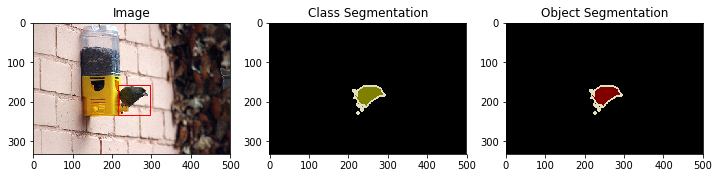

In [6]:
image_name = random.choice(trainf)
image_data = load_image(image_name)
print(image_data['image'])

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 16))
ax1.set_title('Image')
ax1.imshow(image_data['image'])

for i, o in enumerate(image_data['objects']):
    name = o['name']
    xmin, xmax = o['xmin'], o['xmax']
    ymin, ymax = o['ymin'], o['ymax']
    
    rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=1, edgecolor='r', facecolor='none')
    ax1.add_patch(rect)
    
    print('Object %s: %s, %s, %s, %s, %s' % (i, name, xmin, xmax, ymin, ymax))

ax2.set_title('Class Segmentation')
ax2.imshow(image_data['seg_class'])
ax3.set_title('Object Segmentation')
ax3.imshow(image_data['seg_object'])

print(np.unique(np.array(image_data['seg_class'])))

# Selective Search

[(216, 297, 157, 234)]


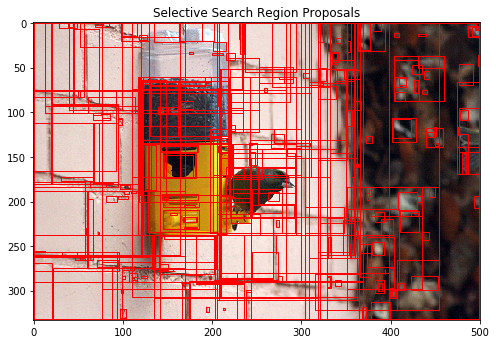

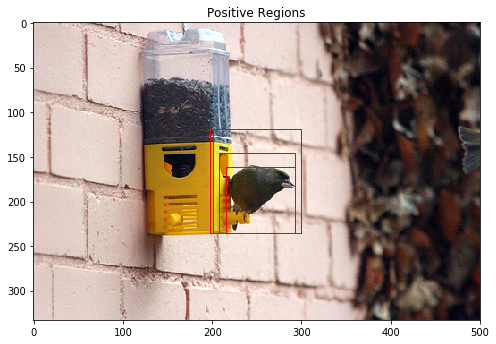

In [7]:
_, regions1 = selectivesearch.selective_search(np.array(image_data['image']), scale=500, sigma=0.9, min_size=10)
_, regions2 = selectivesearch.selective_search(np.array(image_data['image']), scale=1000, sigma=0.9, min_size=10)
regions = regions1 + regions2

fig, ax = plt.subplots(figsize=(8, 12))
ax.set_title('Selective Search Region Proposals')
ax.imshow(image_data['image'])

for r in regions:
    rect = patches.Rectangle((r['rect'][0], r['rect'][1]), r['rect'][2], r['rect'][3], linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    
fig, ax = plt.subplots(figsize=(8, 12))
ax.set_title('Positive Regions')
ax.imshow(image_data['image'])

bnd_boxes = [(o['xmin'], o['xmax'], o['ymin'], o['ymax']) for o in image_data['objects']]
print(bnd_boxes)
for r in regions:
    region = (r['rect'][0] , r['rect'][0] + r['rect'][2], r['rect'][1], r['rect'][1] + r['rect'][3])
    if is_positive(bnd_boxes, region):
        rect = patches.Rectangle((r['rect'][0], r['rect'][1]), r['rect'][2], r['rect'][3], linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

# Fine-tuning CNN

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.autograd import Variable
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models

In [9]:
class VOCDatasetBBox(torch.utils.data.Dataset):
    def __init__(self, imageset):
        self.idx2label = {}
        self.label2idx = {}
        self.counter = 0
        
        self.negative = []
        self.positive = []
        self.npositive = 0
        
        self.imageset = imageset
        
        self.get_labels()
        self.generate_dataset()
        
    def labels(self):
        return self.lable2idx.keys()
    
    def get_labels(self):
        for img in imageset:
            out = parse_xml(img)
            labels = set([o['name'] for o in out['objects']])
            for label in labels:
                if label not in self.label2idx:
                    self.add_label(label)
        self.add_label('background')
                
    def add_label(self, label):
        self.label2idx[label] = self.counter
        self.idx2label[self.counter] = label
        self.counter += 1
    
    def generate_dataset(self):
        for i, image in enumerate(imageset):
            image_data = load_image(image)
            bnd_boxes = [(o['xmin'], o['xmax'], o['ymin'], o['ymax']) for o in image_data['objects']]
            _, regions = selectivesearch.selective_search(np.array(image_data['image']),
                                                             scale=500, sigma=0.9, min_size=10)
            for r in regions:
                region = (r['rect'][0] , r['rect'][0] + r['rect'][2], r['rect'][1], r['rect'][1] + r['rect'][3])
                if self.is_positive(bnd_boxes, region):
                    datum = (imageset, self.label2idx[r['name']]) + region
                    self.positive.append(datum)
                else:
                    datum = (imageset, self.label2idx['background']) + region
                    self.negative.append(datum)
            print(i)

        self.npositive = len(self.positive)
    
    def __len__(self):
        return len(self.positive) + len(self.negative)
    
    def __getitem__(self, index):
        if index < self.npositive:
            return self.positive[index]
        else:
            return self.negative[index - self.npositive]

In [10]:
class VOCDatasetSegmentation(torch.utils.data.Dataset):
    def __init__(self, imageset):
        self.mean = np.array([104.00698793, 116.66876762, 122.67891434])
        self.imageset = imageset
    
    def __len__(self):
        return len(self.imageset)
    
    def __getitem__(self, index):
        data = load_image(self.imageset[index])
        return self.transform(data['image'], data['seg_class'])
    
    def transform(self, image, label):
        image = np.array(image)
        image = image.astype(np.float32)
        image -= self.mean.reshape([1,1,3])
        image = np.transpose(image, (2, 0, 1))
        
        label = np.array(label)
        label[label == 255] = 0
        
        image = torch.from_numpy(image).float()
        label = torch.from_numpy(label).long()
        
        return image, label

In [11]:
class FCN(nn.Module):
    def __init__(self, n_classes=21):
        super(FCN, self).__init__()
        
        self.n_classes = n_classes
        self.criterion = nn.CrossEntropyLoss()
        
        # VGG16 network architecture
        self.conv1_1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=100)
        self.relu1_1 = nn.ReLU()
        self.conv1_2 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.relu1_2 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, dilation=1, ceil_mode=True)
        
        self.conv2_1 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.relu2_1 = nn.ReLU()
        self.conv2_2 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
        self.relu2_2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, dilation=1, ceil_mode=True)
        
        self.conv3_1 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.relu3_1 = nn.ReLU()
        self.conv3_2 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        self.relu3_2 = nn.ReLU()
        self.conv3_3 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        self.relu3_3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2, dilation=1, ceil_mode=True)
        
        self.conv4_1 = nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1)
        self.relu4_1 = nn.ReLU()
        self.conv4_2 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1)
        self.relu4_2 = nn.ReLU()
        self.conv4_3 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1)
        self.relu4_3 = nn.ReLU()
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2, dilation=1, ceil_mode=True)
        
        self.conv5_1 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1)
        self.relu5_1 = nn.ReLU()
        self.conv5_2 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1)
        self.relu5_2 = nn.ReLU()
        self.conv5_3 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1)
        self.relu5_3 = nn.ReLU()
        self.pool5 = nn.MaxPool2d(kernel_size=2, stride=2, dilation=1, ceil_mode=True)
    
        self.conv6 = nn.Conv2d(512, 4096, kernel_size=7)
        self.relu6 = nn.ReLU()
        self.dropout6 = nn.Dropout2d()
        
        self.conv7 = nn.Conv2d(4096, 4096, kernel_size=1)
        self.relu7 = nn.ReLU()
        self.dropout7 = nn.Dropout2d()
        
        self.score_fr = nn.Conv2d(4096, n_classes, 1)
        self.upscore2 = nn.ConvTranspose2d(n_classes, n_classes, kernel_size=4, stride=2, bias=False)
        
        self.score_pool4 = nn.Conv2d(512, n_classes, kernel_size=1)
        self.score_pool3 = nn.Conv2d(256, n_classes, kernel_size=1)
        
        self.upscore_pool4 = nn.ConvTranspose2d(n_classes, n_classes, kernel_size=4, stride=2, bias=False)
        self.upscore8 = nn.ConvTranspose2d(n_classes, n_classes, kernel_size=16, stride=8, bias=False)
        
    def forward(self, input):
        original = input
        input = self.relu1_1(self.conv1_1(input))
        input = self.relu1_2(self.conv1_2(input))
        input = self.pool1(input)
        
        input = self.relu2_1(self.conv2_1(input))
        input = self.relu2_2(self.conv2_2(input))
        input = self.pool2(input)
        
        input = self.relu3_1(self.conv3_1(input))
        input = self.relu3_2(self.conv3_2(input))
        input = self.relu3_3(self.conv3_3(input))
        input = self.pool3(input)
        pool3 = input
        
        input = self.relu4_1(self.conv4_1(input))
        input = self.relu4_2(self.conv4_2(input))
        input = self.relu4_3(self.conv4_3(input))
        input = self.pool4(input)
        pool4 = input
        
        input = self.relu5_1(self.conv5_1(input))
        input = self.relu5_2(self.conv5_2(input))
        input = self.relu5_3(self.conv5_3(input))
        input = self.pool5(input)
        
        input = self.relu6(self.conv6(input))
        input = self.dropout6(input)
        
        input = self.relu7(self.conv7(input))
        input = self.dropout7(input)
        
        score_fr = self.score_fr(input)
        upscore2 = self.upscore2(score_fr)
                
        score_pool4 = self.score_pool4(pool4)
        score_pool4c = score_pool4[:, :, 5:5 + upscore2.size()[2], 5:5 + upscore2.size()[3]]
        fuse_pool4 = score_pool4c + upscore2
        upscore_pool4 = self.upscore_pool4(fuse_pool4)
        
        score_pool3 = self.score_pool3(pool3)
        score_pool3c = score_pool3[:, :,
              9:9 + upscore_pool4.size()[2],
              9:9 + upscore_pool4.size()[3]]
        fuse_pool3 = score_pool3c + upscore_pool4
        upscore8 = self.upscore8(fuse_pool3)
        
        out = upscore8[:, :, 31:31 + original.size()[2], 31:31 + original.size()[3]].contiguous()
        return out
    
    def loss(self, output, label):
        b, c, w, h = output.size() # c = self.n_classes
        output = output.view(b, c, -1)
        label = label.view(b, -1) # b x w*h assuming b == 1
        output = output.squeeze(0).transpose(1, 0) # w*h x c
        label = torch.squeeze(label, 0)
        
        return torch.sum(self.criterion(output, label))

In [12]:
trainset = VOCDatasetSegmentation(trainf)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=1, shuffle=True)

In [13]:
def train(model, optimizer, scheduler, num_epochs=20):
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        running_loss, count = 0.0, 0
        for input, label in iter(train_loader):            
            input = Variable(input)
            label = Variable(label)
            
            optimizer.zero_grad()
            
            output = model(input)
            loss = model.loss(output, label)
            
            loss.backward()
            optimizer.step()
            
            running_loss += loss.data[0]
            count += 1
        print(running_loss / count)
    
    return model

In [ ]:
model = FCN(21)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.8)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.7)

In [ ]:
model = train(model, optimizer, scheduler)

Epoch 0/19
----------
